# Model Performance Analysis


## Imports and Installs

In [6]:
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 565 kB 34.6 MB/s 


In [7]:
# imports
# torch and friends
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10, MNIST
from torchvision import transforms
from PIL import Image, ImageOps
import kornia.augmentation as K

# standard
import os
import random
import time
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## Helper Functions

In [8]:
def load_model(model, pretrained, device):
    weights = torch.load(pretrained, map_location=device)
    model.load_state_dict(weights['model'], strict=False)


def reparameterize(mu, logvar):
    """
    This function applies the reparameterization trick:
    z = mu(X) + sigma(X)^0.5 * epsilon, where epsilon ~ N(0,I)
    :param mu: mean of x
    :param logvar: log variaance of x
    :return z: the sampled latent variable
    """
    device = mu.device
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std).to(device)
    return mu + eps * std


def calc_reconstruction_loss(x, recon_x, loss_type='mse', reduction='sum'):
    """

    :param x: original inputs
    :param recon_x:  reconstruction of the VAE's input
    :param loss_type: "mse", "l1", "bce"
    :param reduction: "sum", "mean", "none"
    :return: recon_loss
    """
    if reduction not in ['sum', 'mean', 'none']:
        raise NotImplementedError
    recon_x = recon_x.view(recon_x.size(0), -1)
    x = x.view(x.size(0), -1)
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='none')
        recon_error = recon_error.sum(1)
        if reduction == 'sum':
            recon_error = recon_error.sum()
        elif reduction == 'mean':
            recon_error = recon_error.mean()
    elif loss_type == 'l1':
        recon_error = F.l1_loss(recon_x, x, reduction=reduction)
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction=reduction)
    else:
        raise NotImplementedError
    return recon_error


def interpolate(model, img_1=None, img_2=None, intervals=10, device="cpu"):
    if img_1 is not None: # encode
        mu, logvar = model.encode(img_1)
        z_1 = reparameterize(mu, logvar)
    else: # sample z ~ N(0,I)
        z_1 = torch.randn(1, model.zdim).to(device)
    
    if img_2 is not None: # encode
        mu, logvar = model.encode(img_2)
        z_2 = reparameterize(mu, logvar)
    else: # sample z ~ N(0,I)
        z_2 = torch.randn(1, model.zdim).to(device)

    images = []
    for i in range(intervals+1):
        t = i / intervals
        z = z_1 * (1-t) + z_2 * t
        img = model.decode(z)
        images.append(img.squeeze(0))
    
    return images

## Model Definition

In [9]:
# Building Blocks
class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super(GaussianNoise, self).__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = torch.normal(mean=torch.zeros_like(x), std=torch.ones_like(x)) * scale
            x = x + sampled_noise
        return x

class AugmentLayers(nn.Module):
    def __init__(self, p_augment=0.9):
        super(AugmentLayers, self).__init__()
        self.p_augment = p_augment
        # self.Affine = K.RandomAffine(degrees=0, translate=(1 / 8, 1 / 8), p=p_augment)
        self.Erase = K.RandomErasing((0.0, 0.1), p=p_augment)

    def forward(self, x):
        # x = self.Affine(x)
        x = self.Erase(x)
        return x

class ResidualBlock(nn.Module):
    """
    https://github.com/hhb072/IntroVAE
    Difference: self.bn2 on output and not on (output + identity)
    """

    def __init__(self, inc=64, outc=64, groups=1, scale=1.0):
        super(ResidualBlock, self).__init__()

        midc = int(outc * scale)

        if inc is not outc:
            self.conv_expand = nn.Conv2d(in_channels=inc, out_channels=outc, kernel_size=1, stride=1, padding=0,
                                         groups=1, bias=False)
        else:
            self.conv_expand = None

        self.conv1 = nn.Conv2d(in_channels=inc, out_channels=midc, kernel_size=3, stride=1, padding=1, groups=groups,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(midc)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(in_channels=midc, out_channels=outc, kernel_size=3, stride=1, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(outc)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        if self.conv_expand is not None:
            identity_data = self.conv_expand(x)
        else:
            identity_data = x
        
        output = self.relu1(self.bn1(self.conv1(x)))
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(torch.add(output, identity_data))
        return output

# Encoder
class Encoder(nn.Module):
    def __init__(self, cdim=3, zdim=512, channels=(64, 128, 256, 512, 512, 512), image_size=256, conditional=False,
                 cond_dim=10, p_enc_s=0, p_enc_e=0, nn_sigma=0, nn_gn_rel=True, p_augment=0):
        super(Encoder, self).__init__()
        self.zdim = zdim
        self.cdim = cdim
        self.image_size = image_size
        self.conditional = conditional
        self.cond_dim = cond_dim
        cc = channels[0]
        self.main = nn.Sequential(
            nn.Conv2d(cdim, cc, 5, 1, 2, bias=False),
            nn.BatchNorm2d(cc),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2),
        )

        if p_augment > 0:
            print("Data augmentation was added")
            self.augment_module = torch.nn.Sequential(
                # K.ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), p=p_augment),
                K.RandomAffine(degrees=0, translate=(1 / 8, 1 / 8), p=p_augment),
                K.RandomErasing((0.0, 0.5), p=p_augment),
            )
        else:
            self.augment_module = nn.Identity()

        gn_i = 0
        if nn_sigma > 0:
            gn_i += 1
            self.main.add_module('GN_{}'.format(gn_i), GaussianNoise(sigma=nn_sigma, is_relative_detach=nn_gn_rel))

        if p_enc_s > 0:
            print("Dropout implemented in the start of the Encoder with value of: ", p_enc_s)
            self.main.add_module('dropout_1', nn.Dropout(p_enc_s))
        
        sz = image_size // 2
        for ch in channels[1:]:
            self.main.add_module('res_in_{}'.format(sz), ResidualBlock(cc, ch, scale=1.0))
            self.main.add_module('down_to_{}'.format(sz // 2), nn.AvgPool2d(2))
            cc, sz = ch, sz // 2
            if nn_sigma > 0:
                gn_i += 1
                self.main.add_module('GN_{}'.format(gn_i), GaussianNoise(sigma=nn_sigma, is_relative_detach=nn_gn_rel))


        self.main.add_module('res_in_{}'.format(sz), ResidualBlock(cc, cc, scale=1.0))

        if nn_sigma > 0:
            gn_i += 1
            self.main.add_module('GN_{}'.format(gn_i), GaussianNoise(sigma=nn_sigma, is_relative_detach=nn_gn_rel))
            print(f"Gaussian noise added to {gn_i} layers of the encoder with sigma = {nn_sigma}, is_relative_detach={nn_gn_rel}")

        if p_enc_e > 0:
            print("Dropout implemented in the end of the encoder with value of: ", p_enc_e)
            self.main.add_module('dropout_2', nn.Dropout(p_enc_e))

        self.conv_output_size = self.calc_conv_output_size()
        num_fc_features = torch.zeros(self.conv_output_size).view(-1).shape[0]
        # print("conv shape: ", self.conv_output_size)
        # print("num fc features: ", num_fc_features)
        if self.conditional:
            self.fc = nn.Linear(num_fc_features + self.cond_dim, 2 * zdim)
        else:
            self.fc = nn.Linear(num_fc_features, 2 * zdim)

    def calc_conv_output_size(self):
        dummy_input = torch.zeros(1, self.cdim, self.image_size, self.image_size)
        dummy_input = self.main(dummy_input)
        return dummy_input[0].shape

    def forward(self, x, o_cond=None):
        if self.training:
            x = self.augment_module(x)

        y = self.main(x).view(x.size(0), -1)
        if self.conditional and o_cond is not None:
            y = torch.cat([y, o_cond], dim=1)
        y = self.fc(y)
        mu, logvar = y.chunk(2, dim=1)
        return mu, logvar

# Decoder
class Decoder(nn.Module):
    def __init__(self, cdim=3, zdim=512, channels=(64, 128, 256, 512, 512, 512), image_size=256, conditional=False,
                 conv_input_size=None, cond_dim=10, p_dec_s=0, p_dec_e=0, nn_sigma=0, nn_gn_rel=True):
        super(Decoder, self).__init__()
        self.cdim = cdim
        self.image_size = image_size
        self.conditional = conditional
        cc = channels[-1]
        self.conv_input_size = conv_input_size
        if conv_input_size is None:
            num_fc_features = cc * 4 * 4
        else:
            num_fc_features = torch.zeros(self.conv_input_size).view(-1).shape[0]
        self.cond_dim = cond_dim
        if self.conditional:
            self.fc = nn.Sequential(
                nn.Linear(zdim + self.cond_dim, num_fc_features),
                nn.ReLU(True),
            )
        else:
            self.fc = nn.Sequential(
                nn.Linear(zdim, num_fc_features),
                nn.ReLU(True),
            )

        gn_i = 0
        if nn_sigma > 0:
            gn_i += 1
            self.fc.add_module('GN_{}'.format(gn_i), GaussianNoise(sigma=nn_sigma, is_relative_detach=nn_gn_rel))

        if p_dec_s > 0:
            print("Dropout implemented in the start of the Decoder with value of: ", p_dec_s)
            self.fc.add_module('dropout_1', nn.Dropout(p_dec_s))
        
        sz = 4

        self.main = nn.Sequential()
        for ch in channels[::-1]:
            self.main.add_module('res_in_{}'.format(sz), ResidualBlock(cc, ch, scale=1.0))
            self.main.add_module('up_to_{}'.format(sz * 2), nn.Upsample(scale_factor=2, mode='nearest'))
            cc, sz = ch, sz * 2
            if nn_sigma > 0:
                gn_i += 1
                self.main.add_module('GN_{}'.format(gn_i), GaussianNoise(sigma=nn_sigma, is_relative_detach=nn_gn_rel))

        if p_dec_e > 0:
            print("Dropout implemented in the end of the Decoder with value of: ", p_dec_e)
            self.main.add_module('dropout_2', nn.Dropout(p_dec_e))

        self.main.add_module('res_in_{}'.format(sz), ResidualBlock(cc, cc, scale=1.0))

        if nn_sigma > 0:
            gn_i += 1
            self.main.add_module('GN_{}'.format(gn_i), GaussianNoise(sigma=nn_sigma, is_relative_detach=nn_gn_rel))
            print(f"Gaussian noise added to {gn_i} layers of the decoder with sigma = {nn_sigma}, is_relative_detach={nn_gn_rel}")

        self.main.add_module('predict', nn.Conv2d(cc, cdim, 5, 1, 2))

    def forward(self, z, y_cond=None):
        z = z.view(z.size(0), -1)
        if self.conditional and y_cond is not None:
            y_cond = y_cond.view(y_cond.size(0), -1)
            z = torch.cat([z, y_cond], dim=1)
        y = self.fc(z)
        y = y.view(z.size(0), *self.conv_input_size)
        y = self.main(y)
        return y

# Soft-IntroVAE
class SoftIntroVAE(nn.Module):
    def __init__(self, cdim=3, zdim=512, channels=(64, 128, 256, 512, 512, 512), image_size=256, conditional=False,
                 cond_dim=10, p_enc_s=0, p_enc_e=0, p_dec_s=0, p_dec_e=0, nn_sigma_enc=0, nn_sigma_dec=0, nn_gn_rel=True,
                 p_augment=0):
        super(SoftIntroVAE, self).__init__()

        self.zdim = zdim
        self.conditional = conditional
        self.cond_dim = cond_dim

        self.encoder = Encoder(cdim, zdim, channels, image_size, conditional=conditional, cond_dim=cond_dim,
                               p_enc_s=p_enc_s, p_enc_e=p_enc_e, nn_sigma=nn_sigma_enc, nn_gn_rel=nn_gn_rel, p_augment=p_augment)

        self.decoder = Decoder(cdim, zdim, channels, image_size, conditional=conditional, conv_input_size=self.encoder.conv_output_size, cond_dim=cond_dim,
                               p_dec_s=p_dec_s, p_dec_e=p_dec_e, nn_sigma=nn_sigma_dec, nn_gn_rel=nn_gn_rel)

    def forward(self, x, o_cond=None, deterministic=False):
        if self.conditional and o_cond is not None:
            mu, logvar = self.encode(x, o_cond=o_cond)
            if deterministic:
                z = mu
            else:
                z = reparameterize(mu, logvar)
            y = self.decode(z, y_cond=o_cond)
        else:
            mu, logvar = self.encode(x)
            if deterministic: 
                z = mu
            else:
                z = reparameterize(mu, logvar)
            y = self.decode(z)
        return mu, logvar, z, y

    def sample(self, z, y_cond=None):
        y = self.decode(z, y_cond=y_cond)
        return y

    def sample_with_noise(self, num_samples=1, device=torch.device("cpu"), y_cond=None):
        z = torch.randn(num_samples, self.zdim).to(device)
        return self.decode(z, y_cond=y_cond)

    def encode(self, x, o_cond=None):
        if self.conditional and o_cond is not None:
            mu, logvar = self.encoder(x, o_cond=o_cond)
        else:
            mu, logvar = self.encoder(x)
        return mu, logvar

    def decode(self, z, y_cond=None):
        if self.conditional and y_cond is not None:
            y = self.decoder(z, y_cond=y_cond)
        else:
            y = self.decoder(z)
        return y

## Analysis

### Load Model

In [1]:
from google.colab import drive
drive.mount('/content/drive') # give notebook access to google drive to load/save checkpoints
base_path = '/content/drive/MyDrive/' # enter path where checkpoint is saved, example: './drive/checkpoints/'

Mounted at /content/drive


In [2]:
import torch
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageOps
import random
import torchvision.transforms as transforms
import os


def load_image(file_path, input_height=128, input_width=None, output_height=128, output_width=None,
               crop_height=None, crop_width=None, is_random_crop=True, is_mirror=True, is_gray=False):
    if input_width is None:
        input_width = input_height
    if output_width is None:
        output_width = output_height
    if crop_width is None:
        crop_width = crop_height

    img = Image.open(file_path)
    if is_gray == False and img.mode != 'RGB':
        img = img.convert('RGB')
    if is_gray and img.mode != 'L':
        img = img.convert('L')

    if is_mirror and random.randint(0, 1) == 0:
        img = ImageOps.mirror(img)

    if input_height is not None:
        img = img.resize((input_width, input_height), Image.BICUBIC)

    if crop_height is not None:
        [w, h] = img.size
        if is_random_crop:
            # print([w,cropSize])
            cx1 = random.randint(0, w - crop_width)
            cx2 = w - crop_width - cx1
            cy1 = random.randint(0, h - crop_height)
            cy2 = h - crop_height - cy1
        else:
            cx2 = cx1 = int(round((w - crop_width) / 2.))
            cy2 = cy1 = int(round((h - crop_height) / 2.))
        img = ImageOps.crop(img, (cx1, cy1, cx2, cy2))

    img = img.resize((output_width, output_height), Image.BICUBIC)
    return img


class ImageDatasetFromFile(data.Dataset):
    def __init__(self, image_list, root_path,
                 input_height=128, input_width=None, output_height=128, output_width=None,
                 crop_height=None, crop_width=None, is_random_crop=False, is_mirror=True, is_gray=False):
        super(ImageDatasetFromFile, self).__init__()

        self.image_filenames = image_list
        self.is_random_crop = is_random_crop
        self.is_mirror = is_mirror
        self.input_height = input_height
        self.input_width = input_width
        self.output_height = output_height
        self.output_width = output_width
        self.root_path = root_path
        self.crop_height = crop_height
        self.crop_width = crop_width
        self.is_gray = is_gray

        self.input_transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __getitem__(self, index):
        img = load_image(join(self.root_path, self.image_filenames[index]),
                         self.input_height, self.input_width, self.output_height, self.output_width,
                         self.crop_height, self.crop_width, self.is_random_crop, self.is_mirror, self.is_gray)

        img = self.input_transform(img)

        return img

    def __len__(self):
        return len(self.image_filenames)


def list_images_in_dir(path):
    valid_images = [".jpg", ".gif", ".png"]
    img_list = []
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        img_list.append(os.path.join(path, f))
    return img_list

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".png", ".jpeg", ".bmp"])

In [4]:
# Parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
dataset = 'celeb64' # Choose dataset: ['cifar10', 'mnist']

z_dim = 256

if dataset == 'cifar10':
  image_size = 32
  channels = [64, 128, 256]
  ch = 3
  checkpoint      = "" # enter checkpoint name, example: 'cifar10_soft_intro_model_epoch_400.pth'
  checkpoint_orig = "" # enter checkpoint name, example: 'cifar10_soft_intro_orig_model_epoch_400.pth'
elif dataset == 'mnist':
  image_size = 28
  channels = [64, 128]
  ch = 1
  checkpoint      = "" # enter checkpoint name, example: 'mnist_soft_intro_model_epoch_400.pth'
  checkpoint_orig = "" # enter checkpoint name, example: 'mnist_soft_intro_orig_model_epoch_400.pth'
elif dataset == 'celeb64':
  channels = [64, 128, 256, 512]
  image_size = 64
  ch = 3
  output_height = 64
  train_size = 162770
  data_root = base_path+'data256x256'
  image_list = [x for x in os.listdir(data_root) if is_image_file(x)]
  train_list = image_list[:train_size]
  assert len(train_list) > 0
  train_set = ImageDatasetFromFile(train_list, data_root, input_height=None, crop_height=None,
                                      output_height=output_height, is_mirror=True)
  checkpoint = "checkpoints/checkpoint_200.pth" # enter checkpoint name, example: 'mnist_soft_intro_model_epoch_400.pth'
  checkpoint_orig = "checkpoints/checkpoint_orig_200.pth" # enter checkpoint name, example: 'mnist_soft_intro_orig_model_epoch_400.pth'
else:
  raise NotImplementedError("Dataset is not supported")

cuda:0


In [31]:
# Load our model
model = SoftIntroVAE(cdim=ch, zdim=z_dim, channels=channels, image_size=image_size).to(device)
load_model(model, base_path + checkpoint, device)
# model.eval()
# Load original model for comparison
model_orig = SoftIntroVAE(cdim=ch, zdim=z_dim, channels=channels, image_size=image_size).to(device)
load_model(model_orig, base_path + checkpoint_orig, device)
# model_orig.eval()
# Load data
if dataset == 'cifar10':
    train_data = CIFAR10(root='./cifar10_ds', train=True, download=True, transform=transforms.ToTensor())  
    test_data  = CIFAR10(root='./cifar10_ds', train=False, download=True, transform=transforms.ToTensor())  
elif dataset == 'mnist':
    train_data = MNIST(root='./mnist_ds', train=True, download=True, transform=transforms.ToTensor())  
    test_data  = MNIST(root='./mnist_ds', train=False, download=True, transform=transforms.ToTensor())  

### Latent Space

#### Latent Map Analysis

In [ ]:
# Encode training data
data_loader = DataLoader(train_data, batch_size=1000, shuffle=True, num_workers=2)
latent_reps = []
labels = []
for i, batch in enumerate(data_loader):
    batch[0].requires_grad = False
    batch[1].requires_grad = False
    imgs = batch[0].to(device)
    lbls = batch[1]
    mu, logvar = model.encode(imgs)
    z = reparameterize(mu, logvar)
    latent_reps.extend(z.detach().numpy())
    labels.extend(lbls.detach().numpy())
    if i == 0:
        break

print(len(latent_reps))
latent_reps = np.asarray(latent_reps)
print(latent_reps.shape)
labels = np.asarray(labels)
print(labels.shape)

if dataset == 'cifar10':
    label_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
elif dataset == 'mnist':
    label_name = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
colors = [color[l] for l in labels]

# use PCA to vizualize latent representations in 2D
map = PCA(n_components=2).fit_transform(latent_reps)
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
ax.scatter(map[:, 0], map[:, 1], c=colors, marker='.')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Latent Representation - PCA")
ax.legend()
legend_elements = []
for i in range(len(label_name)):
    legend_elements.append(Line2D([0], [0], color=color[i], label=label_name[i]))
ax.legend(handles=legend_elements)
plt.show()

# use KPCA to vizualize latent representations in 2D
map = KernelPCA(n_components=2, kernel='cosine', gamma=1/z_dim).fit_transform(latent_reps)
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
ax.scatter(map[:, 0], map[:, 1], c=colors, marker='.')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Latent Representation - KPCA")
ax.legend()
legend_elements = []
for i in range(len(label_name)):
    legend_elements.append(Line2D([0], [0], color=color[i], label=label_name[i]))
ax.legend(handles=legend_elements)
plt.show()

for p in [4, 10, 50, np.sqrt(len(latent_reps))]:
# use T-SNE to vizualize latent representations in 2D
    map = TSNE(n_components=2, perplexity=p, learning_rate='auto', init='pca').fit_transform(latent_reps)
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 7)
    ax.scatter(map[:, 0], map[:, 1], c=colors, marker='.')
    ax.set_xlabel("Mapped dim1")
    ax.set_ylabel("Mapped dim2")
    ax.set_title("Latent Representation - TSNE")
    ax.legend()
    legend_elements = []
    for i in range(len(label_name)):
        legend_elements.append(Line2D([0], [0], color=color[i], label=label_name[i]))
    ax.legend(handles=legend_elements)
    plt.show()

#### Interpolation in the Latent Space

In [ ]:
# Choose source of images to interpolate between: ['trainset', 'testset', 'random', 'cherry']
img_src_1 = 'trainset'
img_src_2 = 'trainset'

# if 'cherry' choose index
idx1 = 12012
idx2 = 11933

train_data_loader = DataLoader(train_data, batch_size=1, shuffle=True, num_workers=1)
test_data_loader  = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=1)

intervals = 20 # choose number of intervals for linear interpolation

In [ ]:
# prepare image 1
if img_src_1 == 'trainset': # take image from train set
    img_1 = next(iter(train_data_loader))
    img_1 = img_1[0].to(device)

elif img_src_1 == 'testset': # take image from test set
    img_1 = next(iter(test_data_loader))
    img_1 = img_1[0].to(device)

elif img_src_1 == 'random': # generate image by sampling z ~ N(0,I)
    img_1 = None

elif img_src_1 == 'cherry':
    img_1 = train_data[idx1][0].unsqueeze(0)

else:
    raise NotImplementedError("Image source is not supported")

# prepare image 1
if img_src_2 == 'trainset': # take image from train set
    img_2 = next(iter(train_data_loader))
    img_2 = img_2[0].to(device)

elif img_src_2 == 'testset': # take image from test set
    img_2 = next(iter(test_data_loader))
    img_2 = img_2[0].to(device)

elif img_src_2 == 'random': # generate image by sampling z ~ N(0,I)
    img_2 = None

elif img_src_2 == 'cherry':
    img_2 = train_data[idx2][0].unsqueeze(0)

else:
    raise NotImplementedError("Image source is not supported")

# interpolate
images = interpolate(model, img_1, img_2, intervals-1, device)
if img_src_1 in ['trainset', 'testset', 'cherry']:
    images[0] = img_1.squeeze(0)
if img_src_2 in ['trainset', 'testset', 'cherry']:
    images[-1] = img_2.squeeze(0)

# save images
if dataset == 'cifar10':
    path = 'figures/cifar10/cifar10_interpolation.jpg'
elif dataset == 'mnist':
    path = 'figures/mnist/mnist_interpolation.jpg'
vutils.save_image(images, base_path + path, nrow=int(intervals/4))

# show images
to_img = transforms.ToPILImage()
fig, axes = plt.subplots(4, int(intervals/4), squeeze=True, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    img = to_img(images[i])
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax.imshow(img)

#### Latent Space Arithmetic

In [ ]:
# Choose source of images: ['trainset', 'testset']
img_src = 'trainset'

In [ ]:
# Prepare data
if img_src == 'trainset':
    data = train_data
else:
    data = test_data
data_loader = DataLoader(data, batch_size=3, shuffle=True, num_workers=2)
image = next(iter(data_loader))
image = image[0].to(device)

# Encode
mu, logvar = model.encode(image)
z = reparameterize(mu, logvar)
# Perform Arithmetic Operation
z_new = z[0] - z[1] + z[2]
# Decode
image_new = model.decode(z_new.unsqueeze(0))
images = torch.cat([image, image_new])

# Save Images
if dataset == 'cifar10':
    path = 'figures/cifar10/cifar10_arithmetic.jpg'
elif dataset == 'mnist':
    path = 'figures/mnist/mnist_arithmetic.jpg'
vutils.save_image(images.data.cpu(), base_path + path, nrow=4)

# Show Images
to_img = transforms.ToPILImage()
fig, axes = plt.subplots(1, 4, squeeze=True, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img = to_img(images[i])
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax.imshow(img)

### Generation

#### Image Generation

In [32]:
# Parameters
b_size = 14

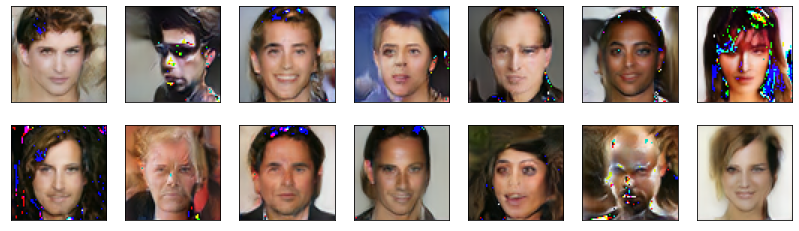

In [33]:
# Create generated image
noise_batch = torch.randn(size=(b_size, z_dim)).to(device)
images = model.sample(noise_batch)

# Save Images
if dataset == 'cifar10':
    path = 'figures/cifar10/cifar10_gen.jpg'
elif dataset == 'mnist':
    path = 'figures/mnist/mnist_gen.jpg'
elif dataset == 'celeb64':
    path = 'figures/celeb64_gen.png'

vutils.save_image(images.data.cpu(), base_path + path, nrow=int(b_size/2))

# Show Images
to_img = transforms.ToPILImage()
fig, axes = plt.subplots(2, int(b_size/2), squeeze=True, figsize=(b_size, 4))
for i, ax in enumerate(axes.flatten()):
    img = to_img(images[i])
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax.imshow(img)

#### Recurring Encoding Decoding for Generated Image Improvement

In [34]:
# Parameters
b_size = 10
num_cycles = 10

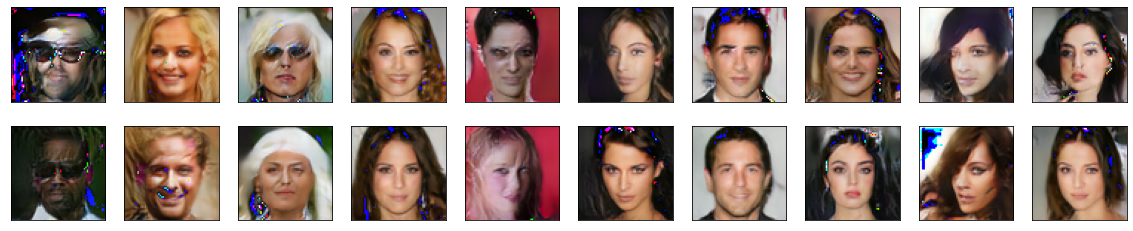

In [35]:
# Create generated image
noise_batch = torch.randn(size=(b_size, z_dim)).to(device)
generated_initial = model.sample(noise_batch)

# Encode-Decode image for num_cycles
generated_rec = generated_initial
for i in range(num_cycles):
    _, _, _, generated_rec = model(generated_rec)
images = torch.cat((generated_initial, generated_rec))

# Save Images
if dataset == 'cifar10':
    path = 'figures/cifar10/cifar10_rec_gen.jpg'
elif dataset == 'mnist':
    path = 'figures/mnist/mnist_rec_gen.jpg'
elif dataset == 'celeb64':
    path = 'figures/celeb64_rec_gen.png'
vutils.save_image(images.data.cpu(), base_path + path, nrow=b_size)

# Show Images
to_img = transforms.ToPILImage()
fig, axes = plt.subplots(2, b_size, squeeze=True, figsize=(2*b_size, 4))
for i, ax in enumerate(axes.flatten()):
    img = to_img(images[i])
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax.imshow(img)

### Reconstruction

#### Image Reconstruction

In [36]:
# Parameters
b_size = 8

# Choose source of images: ['trainset', 'testset']
img_src = 'trainset'

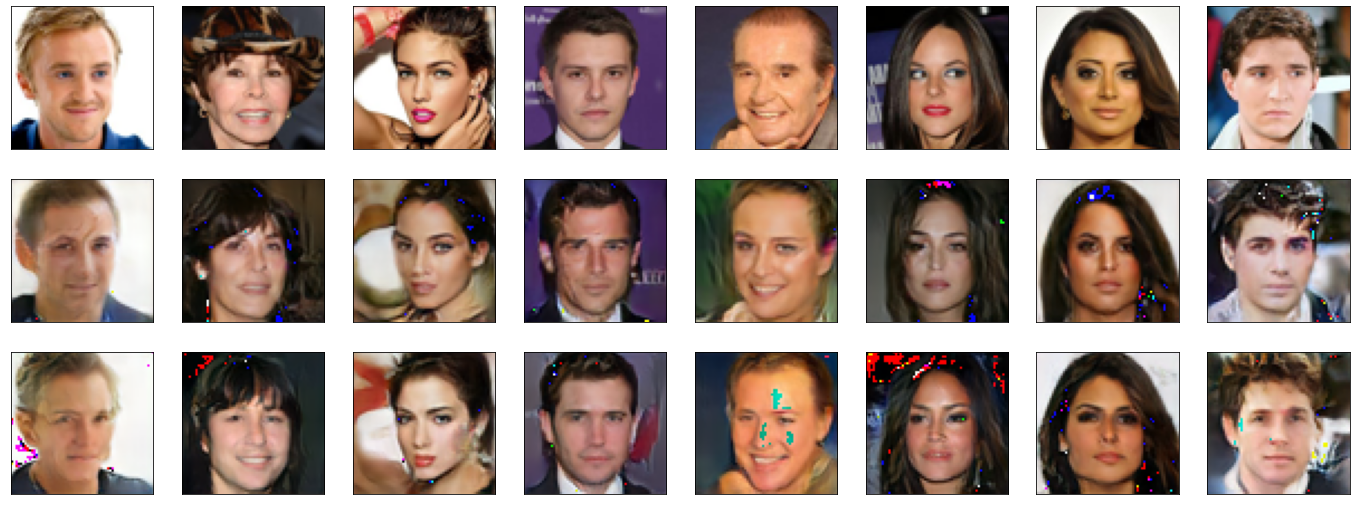

In [37]:
# Prepare data
if img_src == 'trainset':
    data = train_set
else:
    data = test_data
data_loader = DataLoader(data, batch_size=b_size, shuffle=True, num_workers=2)
image = next(iter(data_loader))
image = image.to(device)

# Reconstruct
_, _, _, image_rec = model(image)
_, _, _, image_rec_orig = model_orig(image)
images = torch.cat((image, image_rec, image_rec_orig))

# Save Images
if dataset == 'cifar10':
    path = 'figures/cifar10/cifar10_rec.jpg'
elif dataset == 'mnist':
    path = 'figures/mnist/mnist_rec.jpg'
elif dataset == 'celeb64':
    path = 'figures/celeb64_rec.png'
vutils.save_image(images.data.cpu(), base_path + path, nrow=b_size)

# Show Images
to_img = transforms.ToPILImage()
fig, axes = plt.subplots(3, b_size, squeeze=True, figsize=(3*b_size, 9))
for i, ax in enumerate(axes.flatten()):
    img = to_img(images[i])
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax.imshow(img)

#### Partially Erased Image Reconstruction

In [38]:
# Parameters
b_size = 7
p_augment = 1
num_cycles = 1

# Choose source of images: ['trainset', 'testset']
img_src = 'trainset'

# Choose form of erasing: ['block', 'pixels']
erase = 'block'

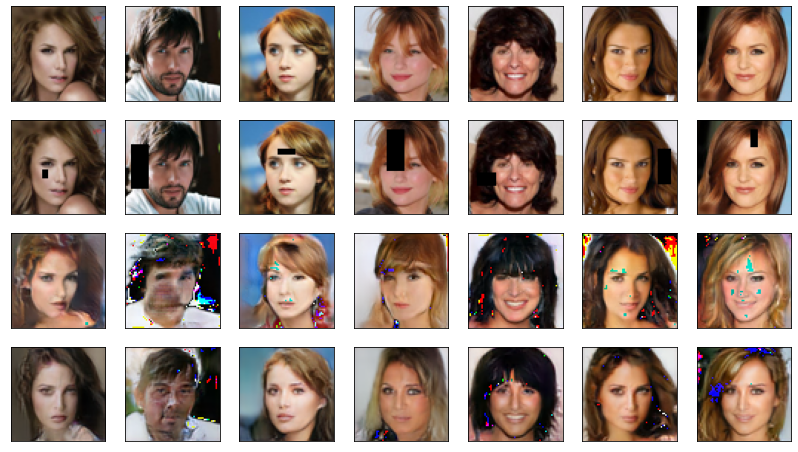

In [39]:
# Prepare data
if img_src == 'trainset':
    data = train_set
else:
    data = test_data
data_loader = DataLoader(data, batch_size=b_size, shuffle=True, num_workers=2)
image = next(iter(data_loader))
image = image.to(device)

# Erase part of image
if erase == 'block':
    AugModule = AugmentLayers(p_augment)
    image_erased = AugModule(image)
elif erase == 'pixels':
    zero_indices = torch.randint(low=0, high=image_size, size=(image.shape[0], int(0.2*np.square(image.shape[2])), 2))
    mask = torch.ones_like(image)
    for n in range(image.shape[0]):
        for i, j in zero_indices[n]:
            mask[n, :, i, j] = 0
    image_erased = image * mask
else:
    raise NotImplementedError("Method is not supported")

# Reconstruct
image_rec = image_erased
image_rec_orig = image_erased

for i in range(num_cycles):
  _, _, _, image_rec = model(image_rec)
  _, _, _, image_rec_orig = model_orig(image_rec_orig)

images = torch.cat((image, image_erased, image_rec_orig, image_rec))

# Save Images
if dataset == 'cifar10':
    path = 'figures/cifar10/cifar10_erased_rec.jpg'
elif dataset == 'mnist':
    path = 'figures/mnist/mnist_erased_rec.jpg'
elif dataset == 'celeb64':
    path = 'figures/celeb64_erased_'+erase+'_rec.png'
vutils.save_image(images.data.cpu(), base_path + path, nrow=b_size)

# Show Images
to_img = transforms.ToPILImage()
fig, axes = plt.subplots(4, b_size, squeeze=True, figsize=(2*b_size, 8))
for i, ax in enumerate(axes.flatten()):
    img = to_img(images[i])
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax.imshow(img)

### Calculate FID

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

# Inception weights ported to Pytorch from
# http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz
FID_WEIGHTS_URL = 'https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth'


class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,  # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False,
                 use_fid_inception=True):
        """Build pretrained InceptionV3
        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, scales the input from range (0, 1) to the range the
            pretrained Inception network expects, namely (-1, 1)
        requires_grad : bool
            If true, parameters of the model require gradients. Possibly useful
            for finetuning the network
        use_fid_inception : bool
            If true, uses the pretrained Inception model used in Tensorflow's
            FID implementation. If false, uses the pretrained Inception model
            available in torchvision. The FID Inception model has different
            weights and a slightly different structure from torchvision's
            Inception model. If you want to compute FID scores, you are
            strongly advised to set this parameter to true to get comparable
            results.
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        if use_fid_inception:
            inception = fid_inception_v3()
        else:
            inception = _inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


def _inception_v3(*args, **kwargs):
    """Wraps `torchvision.models.inception_v3`
    Skips default weight inititialization if supported by torchvision version.
    See https://github.com/mseitzer/pytorch-fid/issues/28.
    """
    try:
        version = tuple(map(int, torchvision.__version__.split('.')[:2]))
    except ValueError:
        # Just a caution against weird version strings
        version = (0,)

    if version >= (0, 6):
        kwargs['init_weights'] = False

    return torchvision.models.inception_v3(*args, **kwargs)


def fid_inception_v3():
    """Build pretrained Inception model for FID computation
    The Inception model for FID computation uses a different set of weights
    and has a slightly different structure than torchvision's Inception.
    This method first constructs torchvision's Inception and then patches the
    necessary parts that are different in the FID Inception model.
    """
    inception = _inception_v3(num_classes=1008,
                              aux_logits=False,
                              pretrained=False)
    inception.Mixed_5b = FIDInceptionA(192, pool_features=32)
    inception.Mixed_5c = FIDInceptionA(256, pool_features=64)
    inception.Mixed_5d = FIDInceptionA(288, pool_features=64)
    inception.Mixed_6b = FIDInceptionC(768, channels_7x7=128)
    inception.Mixed_6c = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6d = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6e = FIDInceptionC(768, channels_7x7=192)
    inception.Mixed_7b = FIDInceptionE_1(1280)
    inception.Mixed_7c = FIDInceptionE_2(2048)

    state_dict = load_state_dict_from_url(FID_WEIGHTS_URL, progress=True)
    inception.load_state_dict(state_dict)
    return inception


class FIDInceptionA(torchvision.models.inception.InceptionA):
    """InceptionA block patched for FID computation"""

    def __init__(self, in_channels, pool_features):
        super(FIDInceptionA, self).__init__(in_channels, pool_features)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionC(torchvision.models.inception.InceptionC):
    """InceptionC block patched for FID computation"""

    def __init__(self, in_channels, channels_7x7):
        super(FIDInceptionC, self).__init__(in_channels, channels_7x7)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_1(torchvision.models.inception.InceptionE):
    """First InceptionE block patched for FID computation"""

    def __init__(self, in_channels):
        super(FIDInceptionE_1, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_2(torchvision.models.inception.InceptionE):
    """Second InceptionE block patched for FID computation"""

    def __init__(self, in_channels):
        super(FIDInceptionE_2, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: The FID Inception model uses max pooling instead of average
        # pooling. This is likely an error in this specific Inception
        # implementation, as other Inception models use average pooling here
        # (which matches the description in the paper).
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

In [41]:
import os
import pathlib
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

import numpy as np
import torch
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
import torchvision.utils as vutils

from PIL import Image
import logging
# from dataset import ImageDatasetFromFile
from torch.utils.data import DataLoader
# from networks import IntroVAE
from pathlib import Path

def imread(filename):
    """
    Loads an image file into a (height, width, 3) uint8 ndarray.
    """
    return np.asarray(Image.open(filename), dtype=np.uint8)[..., :3]


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".png", ".jpeg", ".bmp"])


# def load_model(model, pretrained, device):
#     weights = torch.load(pretrained, map_location=device)
#     model.load_state_dict(weights['model'].state_dict())

def load_model(model, pretrained, device):
    weights = torch.load(pretrained, map_location=device)
    pretrained_dict = weights['model'].state_dict()
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)


def get_activations(files, model, batch_size=50, dims=2048,
                    cuda=False, verbose=False, device=torch.device("cpu")):
    """Calculates the activations of the pool_3 layer for all images.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the number
                     of calculated batches is reported.
    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    pred_arr = np.empty((len(files), dims))
    n_batches = len(files) // batch_size
    for i in tqdm(range(0, len(files), batch_size)):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches),
                  end='', flush=True)
        start = i
        end = i + batch_size

        images = np.array([imread(str(f)).astype(np.float32)
                           for f in files[start:end]])

        # Reshape to (n_images, 3, height, width)
        images = images.transpose((0, 3, 1, 2))
        images /= 255

        batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            batch = batch.to(device)

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(pred.size(0), -1)

    if verbose:
        print(' done')

    return pred_arr


def get_activations_given_dataset(dataloader, model, batch_size=50, dims=2048,
                                  cuda=False, verbose=False, device=torch.device("cpu"), num_images=50000):
    """Calculates the activations of the pool_3 layer for all images.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the number
                     of calculated batches is reported.
    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    # model.eval()
    logger = logging.getLogger("logger")
    logger.setLevel(logging.DEBUG)
    activations = []
    num_images_processed = 0
    for idx, batch in enumerate(dataloader):
        if len(batch) == 2 or len(batch) == 3:
            batch = batch[0]
        if cuda:
            batch = batch.to(device)
        res = model(batch)[0]
        # if idx == 0:
        #     print(batch[0].min())
        #     print(batch[0].max())
        #     print("real images shape: ", batch.shape)
        #     print("res output shape:" , res.shape)
        # res = inception.run(x, num_gpus=gpu_count, assume_frozen=True)
        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if res.size(2) != 1 or res.size(3) != 1:
            res = adaptive_avg_pool2d(res, output_size=(1, 1))
        activations.append(res.cpu().data.numpy().reshape(res.size(0), -1))
        num_images_processed += batch.shape[0]
        if num_images_processed > num_images:
            # print("num img proc.: ", num_images_processed, " num img req.:, ", num_images)
            break
    activations = np.concatenate(activations)
    activations = activations[:num_images]
    print("total real activations: ", activations.shape)
    # print("num images processed: ", num_images_processed)

    if verbose:
        print(' done')

    return activations


def get_activations_generate(model_s, model, batch_size=50, dims=2048,
                             cuda=False, verbose=False, device=torch.device("cpu"), num_images=50000):
    """Calculates the activations of the pool_3 layer for all images.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the number
                     of calculated batches is reported.
    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    # model.eval()
    # logger = logging.getLogger("logger")
    # logger.setLevel(logging.DEBUG)
    # lod = cfg.DATASET.MAX_RESOLUTION_LEVEL - 2
    # dataset = TFRecordsDataset(cfg, logger, rank=0, world_size=1, buffer_size_mb=1024,
    #                            channels=cfg.MODEL.CHANNELS, train=True)
    # dataset.reset(lod + 2, batch_size)
    # batches = make_dataloader(cfg, logger, dataset, batch_size, 0, numpy=True)
    activations = []
    num_images_processed = 0
    # for _ in tqdm(range(0, num_images, batch_size)):
    for i in range(0, num_images, batch_size):
        # torch.cuda.set_device(0)
        noise_batch = torch.randn(size=(batch_size, model_s.zdim)).to(device)
        images = model_s.sample(noise_batch)
        # images = model_s.generate(lod, 1, count=batch_size, no_truncation=True)
        images = images.data.cpu().numpy()
        images = np.clip(images * 255, 0, 255).astype(np.uint8)

        # images = np.clip((images.cpu().numpy() + 1.0) * 127, 0, 255).astype(np.uint8)
        images = images / 255.0
        # if i == 0:
        #     print(images[0].min())
        #     print(images[0].max())
        batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            batch = batch.to(device)
        res = model(batch)[0]

        activations.append(res.cpu().data.numpy().reshape(res.size(0), -1))

    activations = np.concatenate(activations)
    activations = activations[:num_images]
    print("total generated activations: ", activations.shape)

    if verbose:
        print(' done')

    return activations


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics_given_dataset(dataloader, model, batch_size=50,
                                                  dims=2048, cuda=False, verbose=False, device=torch.device("cpu"),
                                                  num_images=50000):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the
                     number of calculated batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations_given_dataset(dataloader, model, batch_size, dims, cuda, verbose, device, num_images)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def calculate_activation_statistics_generate(model_s, model, batch_size=50,
                                             dims=2048, cuda=False, verbose=False, device=torch.device("cpu"),
                                             num_images=50000):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the
                     number of calculated batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations_generate(model_s, model, batch_size, dims, cuda, verbose, device, num_images)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def calculate_activation_statistics(files, model, batch_size=50,
                                    dims=2048, cuda=False, verbose=False, device=torch.device("cpu")):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the
                     number of calculated batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(files, model, batch_size, dims, cuda, verbose, device)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def _compute_statistics_of_path(path, model, batch_size, dims, cuda, device):
    if path.endswith('.npz'):
        f = np.load(path)
        m, s = f['mu'][:], f['sigma'][:]
        f.close()
    else:
        path = pathlib.Path(path)
        files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
        m, s = calculate_activation_statistics(files, model, batch_size,
                                               dims, cuda, device=device)

    return m, s


def _compute_statistics_of_given_dataset(dataloader, model, batch_size, dims, cuda, device, num_images):
    m, s = calculate_activation_statistics_given_dataset(dataloader, model, batch_size,
                                                         dims, cuda, device=device, num_images=num_images)

    return m, s


def _compute_statistics_of_generate(model_s, model, batch_size, dims, cuda, device, num_images):
    m, s = calculate_activation_statistics_generate(model_s, model, batch_size,
                                                    dims, cuda, device=device, num_images=num_images)

    return m, s


def calculate_fid_given_paths(paths, batch_size, cuda, dims, device):
    """Calculates the FID of two paths"""
    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError('Invalid path: %s' % p)

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    if cuda:
        model.to(device)

    m1, s1 = _compute_statistics_of_path(paths[0], model, batch_size,
                                         dims, cuda, device)
    m2, s2 = _compute_statistics_of_path(paths[1], model, batch_size,
                                         dims, cuda, device)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value


def calculate_fid_given_dataset(dataloader, model_s, batch_size, cuda, dims, device, num_images):
    """Calculates the FID"""

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    if cuda:
        model.to(device)

    m1, s1 = _compute_statistics_of_given_dataset(dataloader, model, batch_size,
                                                  dims, cuda, device, num_images)
    m2, s2 = _compute_statistics_of_generate(model_s, model, batch_size,
                                             dims, cuda, device, num_images)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value


def save_from_dataset(img_datasetloader, save_path, num_images):
    """
    Saves images from ImageDataset.
    :param img_dataset:
    :param save_path:
    :param num_images:
    :return:
    """
    count = 0
    for batch in img_datasetloader:
        if count >= num_images:
            break
        num_images_in_batch = len(batch)
        for i in range(num_images_in_batch):
            vutils.save_image(batch[i].data.cpu(), save_path + '/image_{}.jpg'.format(count), nrow=1)
            count += 1


def generate_from_model(model, save_path, num_images, batch_size=32, device=torch.device("cpu")):
    """
    Generate images from model
    """
    count = 0
    model.eval()
    while count < num_images:
        noise_batch = torch.randn(size=(batch_size, model.zdim)).to(device)
        generated = model.sample(noise_batch)
        for i in range(len(generated)):
            if count >= num_images:
                break
            vutils.save_image(generated[i].data.cpu(), save_path + '/image_{}.jpg'.format(count), nrow=1)
            count += 1


def calc_fid_from_dataset_generate(cfg, dataset, model_s, batch_size, cuda, dims, device, num_images):
    with torch.no_grad():
        fid = calculate_fid_given_dataset(cfg, dataset, model_s, batch_size, cuda, dims, device, num_images)
        # sanity check
        # fid = calculate_fid_given_dataset_sanity(cfg, dataset, model_s, batch_size, cuda, dims, device, num_images)
    return fid

In [42]:
train_data_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)

In [ ]:
with torch.no_grad():
  print("calculating fid...")
  fid = calculate_fid_given_dataset(data_loader, model, batch_size=256, cuda=True, dims=2048,
                                    device=device, num_images=50000)
  print("fid:", fid)

calculating fid...


In [ ]:
with torch.no_grad():
  print("calculating fid...")
  fid = calculate_fid_given_dataset(data_loader, model_orig, batch_size=256, cuda=True, dims=2048,
                                    device=device, num_images=50000)
  print("fid:", fid)  